In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.2


In [ ]:
from tensorflow import keras

In [ ]:
import keras

In [ ]:
pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 7.8 MB/s 


In [ ]:
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
classes = 10 

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
epochs=100
batch_size=128
hidden_activation='relu'
output_activation='softmax'
optimizer=Adam()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
verbose=0

np.random.seed(1924) 
set_seed(21) 
    
input = Input(shape=(28,28), name='Input')
input_flatten = Flatten(name='Flatten_Image')(input)
output = Dense(units=classes, kernel_initializer='glorot_uniform', activation=output_activation, name='Output')(input_flatten)

baseline_model = Model(inputs=input, outputs=output)
baseline_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
baseline_hs = baseline_model.fit(x=X_train, y=Y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[early_stopping], batch_size=batch_size)

baseline_model.summary() 

Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28)]          0         
                                                                 
 Flatten_Image (Flatten)     (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plot_history(hs, model, x_train, y_train, x_test, y_test):
  score_tr = model.evaluate(x_train, y_train, verbose=0)
  print('Train accuracy:', round(score_tr[1],4))
  score_ts = model.evaluate(x_test, y_test, verbose=0)
  print('Test accuracy:', round(score_ts[1],4))
  
  print()
  plt.rcParams['figure.figsize'] = [8,5]
  plt.rcParams['font.size'] = 14
  plt.clf()
  plt.plot(hs.history['loss'])
  plt.plot(hs.history['val_loss'])
  plt.title('Loss vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

In [ ]:
plot_history(baseline_hs, baseline_model, X_train, Y_train, X_test, Y_test)

In [ ]:
b_model = keras.Sequential()
b_model.add(keras.layers.Flatten(input_shape=(28,28)))
b_model.add(keras.layers.Dense(units=512, activation='relu', name='dense_1'))
b_model.add(keras.layers.Dropout(0.2))
b_model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
b_model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
b_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
b_model_hs = b_model.fit(x=X_train, y=Y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[early_stopping], batch_size=batch_size)

Restoring model weights from the end of the best epoch: 52.
Epoch 62: early stopping


Train accuracy: 0.9624
Test accuracy: 0.8956



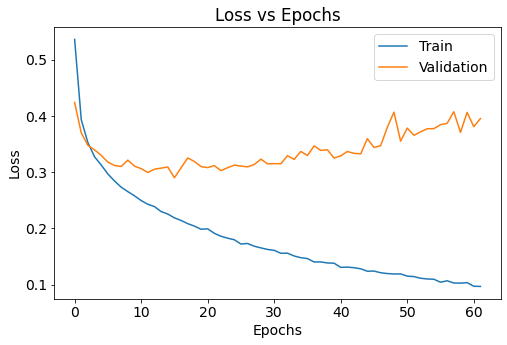

In [ ]:
plot_history(b_model_hs, b_model, X_train, Y_train, X_test, Y_test)

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    for i in range(hp.Int("layers", 2, 5)):
        model.add(
            Dense(
                units=hp.Int("units_" + str(i), min_value=256, max_value=512, step=128),
                activation=hp.Choice('activation', ['relu', 'tanh']))
            )
        
        
        model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(Dense(units=10, activation="softmax"))
    model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])
    
    return model

In [ ]:
tuner_hyperband = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=10,
                     overwrite=True,
                     directory="kt_dir",
                     project_name="kt_hyperband")

In [ ]:
tuner_hyperband.search_space_summary()

Search space summary
Default search space size: 7
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

tuner_hyperband.search(X_train, Y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping])

Trial 30 Complete [00h 01m 22s]
val_accuracy: 0.10316666960716248

Best val_accuracy So Far: 0.8924999833106995
Total elapsed time: 00h 16m 22s
INFO:tensorflow:Oracle triggered exit


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
best_hps=tuner_hyperband.get_best_hyperparameters()[0]

h_model_hyper = tuner_hyperband.hypermodel.build(best_hps)

hs_h_model_hyper = h_model_hyper.fit(X_train, Y_train, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.7090 - accuracy: 0.7449 - val_loss: 0.4411 - val_accuracy: 0.8395
Epoch 2/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4409 - accuracy: 0.8434 - val_loss: 0.3890 - val_accuracy: 0.8590
Epoch 3/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3894 - accuracy: 0.8602 - val_loss: 0.3549 - val_accuracy: 0.8690
Epoch 4/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3569 - accuracy: 0.8711 - val_loss: 0.3649 - val_accuracy: 0.8727
Epoch 5/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3363 - accuracy: 0.8776 - val_loss: 0.3469 - val_accuracy: 0.8762
Epoch 6/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3203 - accuracy: 0.8837 - val_loss: 0.3326 - val_accuracy: 0.8813
Epoch 7/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3066 - accuracy: 0.8885 - val_loss: 0.3371 - val_ac

Train accuracy: 0.9497
Test accuracy: 0.8938



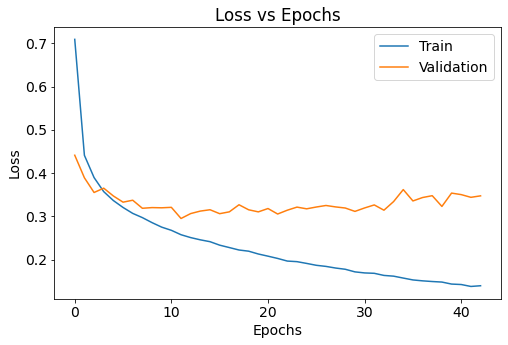

In [ ]:
plot_history(hs_h_model_hyper, h_model_hyper, X_train, Y_train, X_test, Y_test)

In [ ]:
tuner = kt.BayesianOptimization(build_model,
                     objective="val_accuracy",
                     max_trials=10,
                     overwrite=True)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

tuner.search(X_train, Y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping])

Trial 10 Complete [00h 02m 07s]
val_accuracy: 0.8993333578109741

Best val_accuracy So Far: 0.8995000123977661
Total elapsed time: 00h 21m 15s
INFO:tensorflow:Oracle triggered exit


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
best_hps=tuner.get_best_hyperparameters()[0]

h_model = tuner.hypermodel.build(best_hps)

hs_h_model = h_model.fit(X_train, Y_train, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.6372 - accuracy: 0.7706 - val_loss: 0.4143 - val_accuracy: 0.8460
Epoch 2/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4169 - accuracy: 0.8489 - val_loss: 0.3773 - val_accuracy: 0.8603
Epoch 3/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3743 - accuracy: 0.8625 - val_loss: 0.3556 - val_accuracy: 0.8725
Epoch 4/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3497 - accuracy: 0.8705 - val_loss: 0.3600 - val_accuracy: 0.8725
Epoch 5/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3288 - accuracy: 0.8801 - val_loss: 0.3370 - val_accuracy: 0.8788
Epoch 6/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3163 - accuracy: 0.8830 - val_loss: 0.3262 - val_accuracy: 0.8830
Epoch 7/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3034 - accuracy: 0.8871 - val_loss: 0.3317 - val_ac

Train accuracy: 0.9464
Test accuracy: 0.8984



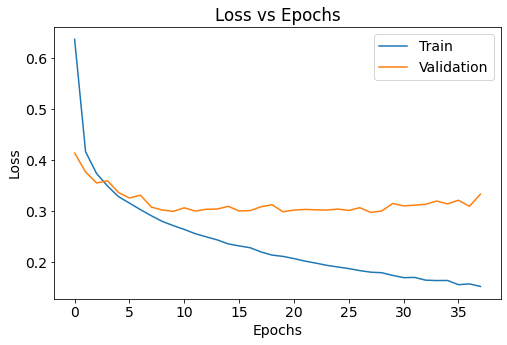

In [ ]:
plot_history(hs_h_model, h_model, X_train, Y_train, X_test, Y_test)

In [ ]:
def build_model_SGD(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    for i in range(hp.Int("layers", 2, 5)):
        model.add(
            Dense(
                units=hp.Int("units_" + str(i), min_value=256, max_value=512, step=128),
                activation=hp.Choice('activation', ['relu', 'tanh']))
            )
        
        
        model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(Dense(units=10, activation="softmax"))
    model.compile(optimizer=SGD(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])
    
    return model

In [ ]:
tunerSGD = kt.BayesianOptimization(build_model_SGD,
                     objective="val_accuracy",
                     max_trials=10,
                     overwrite=True)

In [ ]:
tunerSGD.search_space_summary()

Search space summary
Default search space size: 7
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

tunerSGD.search(X_train, Y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping])

Trial 10 Complete [00h 02m 22s]
val_accuracy: 0.8821666836738586

Best val_accuracy So Far: 0.8859999775886536
Total elapsed time: 00h 23m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
best_hps=tunerSGD.get_best_hyperparameters()[0]

h_modelSGD = tunerSGD.hypermodel.build(best_hps)

hs_h_modelSGD = h_modelSGD.fit(X_train, Y_train, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.9890 - accuracy: 0.6396 - val_loss: 0.5530 - val_accuracy: 0.7952
Epoch 2/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.5577 - accuracy: 0.8019 - val_loss: 0.4507 - val_accuracy: 0.8388
Epoch 3/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4784 - accuracy: 0.8304 - val_loss: 0.4038 - val_accuracy: 0.8492
Epoch 4/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4339 - accuracy: 0.8451 - val_loss: 0.3902 - val_accuracy: 0.8588
Epoch 5/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.4090 - accuracy: 0.8530 - val_loss: 0.3790 - val_accuracy: 0.8615
Epoch 6/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3874 - accuracy: 0.8601 - val_loss: 0.3596 - val_accuracy: 0.8687
Epoch 7/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3721 - accuracy: 0.8654 - val_loss: 0.3480 - val_ac

Train accuracy: 0.9434
Test accuracy: 0.895



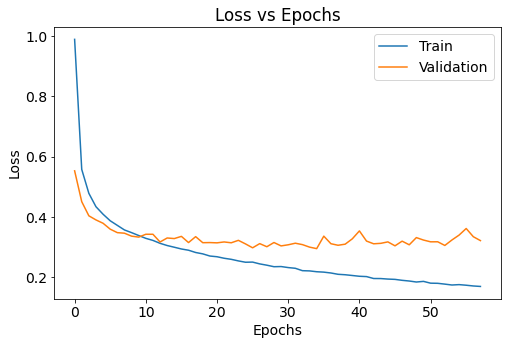

In [ ]:
plot_history(hs_h_modelSGD, h_modelSGD, X_train, Y_train, X_test, Y_test)

In [ ]:
def build_model_CNN(hp):
    model = keras.Sequential([
                              Conv2D(
                                  filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                                  kernel_size=hp.Int('conv_1_kernel', 3,5),
                                  activation=hp.Choice('activation', ['relu', 'tanh']),
                                  input_shape=(28, 28, 1),
                                  
                              ),
                              MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D1'),
                              Dropout(hp.Float("dropout_1", 0, 0.5, step=0.1)),
                              Conv2D(
                                  filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                                  kernel_size=hp.Int('conv_2_kernel',3,5),
                                  activation=hp.Choice('activation', ['relu', 'tanh'])
                              ),
                              MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D2'),
                              Dropout(hp.Float("dropout_2", 0, 0.5, step=0.1)),
                              Conv2D(
                                  filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
                                  kernel_size=hp.Int('conv_3_kernel',3,5),
                                  activation=hp.Choice('activation', ['relu', 'tanh'])
                              ),
                              MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D3'),
                              Dropout(hp.Float("dropout_3", 0, 0.5, step=0.1)),
                              Flatten(),
                              Dense(
                                  units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                                  activation=hp.Choice('activation', ['relu', 'tanh'])
                              ),
                              Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4,  1e-5])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tuner_hyperband_CNN = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=70,
                     overwrite=True,
                     directory="kt_dir",
                     project_name="kt_hyperband")

In [ ]:
tuner_CNN = kt.BayesianOptimization(build_model_CNN,
                     objective="val_accuracy",
                     max_trials=10,
                     overwrite=True)

In [ ]:
tuner_hyperband_CNN.search_space_summary()

Search space summary
Default search space size: 7
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

tuner_hyperband_CNN.search(X_train, Y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Trial 90 Complete [00h 04m 32s]
val_accuracy: 0.8970000147819519

Best val_accuracy So Far: 0.9043333530426025
Total elapsed time: 01h 48m 56s
INFO:tensorflow:Oracle triggered exit


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
best_hps_CNN=tuner_hyperband_CNN.get_best_hyperparameters()[0]

cnnmodel = tuner_hyperband_CNN.hypermodel.build(best_hps_CNN)

hs_cnn_model = cnnmodel.fit(X_train, Y_train, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.6168 - accuracy: 0.7830 - val_loss: 0.4198 - val_accuracy: 0.8448
Epoch 2/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4060 - accuracy: 0.8525 - val_loss: 0.3747 - val_accuracy: 0.8640
Epoch 3/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3625 - accuracy: 0.8689 - val_loss: 0.3571 - val_accuracy: 0.8665
Epoch 4/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3336 - accuracy: 0.8779 - val_loss: 0.3514 - val_accuracy: 0.8768
Epoch 5/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3091 - accuracy: 0.8863 - val_loss: 0.3415 - val_accuracy: 0.8783
Epoch 6/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2941 - accuracy: 0.8914 - val_loss: 0.3238 - val_accuracy: 0.8840
Epoch 7/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2778 - accuracy: 0.8978 - val_loss: 0.3499 - val_ac

Train accuracy: 0.962
Test accuracy: 0.8966



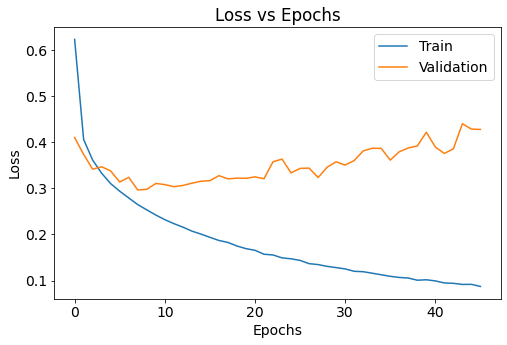

In [ ]:
plot_history(hs_cnn_model, cnnmodel, X_train, Y_train, X_test, Y_test)

In [ ]:
def build_model_CNN_SGD(hp):
    model = keras.Sequential([
                              Conv2D(
                                  filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
                                  kernel_size=hp.Int('conv_1_kernel', 3,5),
                                  activation='relu',
                                  input_shape=(28, 28, 1),
                                  
                              ),
                              MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D1'),
                              Dropout(rate=0.3, name='Dropout1'),
                              Conv2D(
                                  filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=32),
                                  kernel_size=hp.Int('conv_2_kernel', 3,5),
                                  activation='relu'
                              ),
                              MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D2'),
                              Dropout(rate=0.4, name='Dropout2'),
                              Conv2D(
                                  filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=32),
                                  kernel_size=hp.Int('conv_3_kernel', 3,5),
                                  activation='relu'
                              ),
                              MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D3'),
                              Dropout(rate=0.5, name='Dropout3'),
                              Flatten(),
                              Dense(
                                  units=hp.Int('dense_1_units', min_value=32, max_value=128, step=32),
                                  activation='relu'
                              ),
                              Dense(10, activation='softmax')
    ])
    model.compile(optimizer=SGD(hp.Choice('learning_rate', values=[1e-2, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tuner_CNNSGD = kt.BayesianOptimization(build_model_CNN_SGD,
                     objective="val_accuracy",
                     max_trials=10,
                     overwrite=True)

In [ ]:
tuner_CNNSGD.search_space_summary()

Search space summary
Default search space size: 8
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': None}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

tuner_CNNSGD.search(X_train, Y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping])

Trial 10 Complete [00h 03m 22s]
val_accuracy: 0.8473333120346069

Best val_accuracy So Far: 0.8765000104904175
Total elapsed time: 00h 31m 01s
INFO:tensorflow:Oracle triggered exit


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
best_hps_CNNSGD=tuner_CNNSGD.get_best_hyperparameters()[0]

cnnmodelSGD = tuner_CNNSGD.hypermodel.build(best_hps_CNNSGD)

hs_cnn_modelSGD = cnnmodelSGD.fit(X_train, Y_train, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
1688/1688 [==============================] - 8s 4ms/step - loss: 1.4322 - accuracy: 0.4563 - val_loss: 0.7771 - val_accuracy: 0.6890
Epoch 2/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.8290 - accuracy: 0.6806 - val_loss: 0.6445 - val_accuracy: 0.7495
Epoch 3/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.7263 - accuracy: 0.7205 - val_loss: 0.5870 - val_accuracy: 0.7733
Epoch 4/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.6680 - accuracy: 0.7446 - val_loss: 0.5431 - val_accuracy: 0.7875
Epoch 5/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.6295 - accuracy: 0.7624 - val_loss: 0.5169 - val_accuracy: 0.7962
Epoch 6/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.6015 - accuracy: 0.7720 - val_loss: 0.4906 - val_accuracy: 0.8130
Epoch 7/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.5771 - accuracy: 0.7841 - val_loss: 0.4664 - val_ac

Train accuracy: 0.9223
Test accuracy: 0.9104



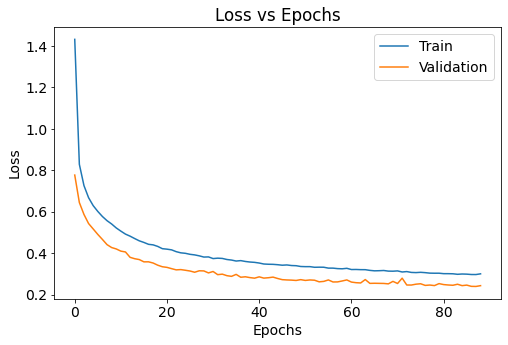

In [ ]:
plot_history(hs_cnn_modelSGD, cnnmodelSGD, X_train, Y_train, X_test, Y_test)

In [ ]:
h_modelSGD.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 512)              

In [ ]:
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 96)        960       
                                                                 
 MaxPool2D1 (MaxPooling2D)   (None, 13, 13, 96)        0         
                                                                 
 Dropout1 (Dropout)          (None, 13, 13, 96)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 64)          153664    
                                                                 
 MaxPool2D2 (MaxPooling2D)   (None, 5, 5, 64)          0         
                                                                 
 Dropout2 (Dropout)          (None, 5, 5, 64)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)         

In [ ]:
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 384)               196992    
                                                                 
 dropout_6 (Dropout)         (None, 384)               0         
                                                                 
 dense_8 (Dense)             (None, 384)               147840    
                                                                 
 dropout_7 (Dropout)         (None, 384)              

In [ ]:
h_model_hyper.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 384)               301440    
                                                                 
 dropout_5 (Dropout)         (None, 384)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               98560     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 384)               98688     
                                                                 
 dropout_7 (Dropout)         (None, 384)              

In [ ]:
tuner_hyperbandCNN = kt.Hyperband(build_model_CNN,
                     objective="val_accuracy",
                     max_epochs=20,
                     overwrite=True,
                     directory="kt_dir",
                     project_name="kt_hyperband")

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

tuner_hyperbandCNN.search(X_train, Y_train, epochs=40, validation_split=0.1, callbacks=[early_stopping])

Trial 29 Complete [00h 01m 03s]
val_accuracy: 0.7741666436195374

Best val_accuracy So Far: 0.8913333415985107
Total elapsed time: 00h 30m 55s

Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
64                |64                |conv_1_filter
4                 |4                 |conv_1_kernel
64                |32                |conv_2_filter
4                 |4                 |conv_2_kernel
64                |64                |conv_3_filter
4                 |5                 |conv_3_kernel
96                |32                |dense_1_units
0.0001            |0.0001            |learning_rate
20                |20                |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |0                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/20
1688/1688 [==============================] - 9s 5ms/step - loss: 1.2105 - accuracy: 0.5512 - val_loss: 0.6935 - val_accuracy: 0.7443
Epoc